<a href="https://colab.research.google.com/github/xiaohetongxue/machine_learning_beginner/blob/master/docs/pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inspecting deep neural networks with NoPdb

[NoPdb](https://github.com/cifkao/nopdb) is a **programmatic** (non-interactive) **debugger** for Python. This means it gives you access to **debugger-like superpowers** directly from your code.

This notebook shows how to use NoPdb to dissect a pre-trained [**Vision Transformer (ViT)**](https://arxiv.org/abs/2010.11929), allowing to **plot** and even **modify** its attention weights, which are normally not accessible from user code. We are going to use a pre-trained ViT from the [`timm`](https://github.com/rwightman/pytorch-image-models) package, which contains easy-to-use PyTorch implementations of many computer vision models.

[This blog post](https://ondrej.cifka.com/posts/dissecting-ml-models-with-nopdb/)/[Medium article](https://towardsdatascience.com/dissecting-ml-models-with-nopdb-6ff4651fb131) is based on this notebook and provides a much more detailed explanation.

## Install and import packages

In [44]:
!pip install nopdb
!pip install timm==0.4.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [1]:
import urllib

import IPython.display as ipd
import numpy as np
import PIL
import timm
from timm.data import resolve_data_config, create_transform
import torch

import nopdb

## Load the model

In [2]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.cuda()
model.eval()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (pre_logits): Identity(

## Download some data

In [ ]:
# Download an input image
!wget https://raw.githubusercontent.com/cifkao/nopdb/data/cows.jpg

In [17]:
# Get imagenet class names
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]
# classes = [
    # "dog",
    # "frisbee",
    # "glasses",
    # ]

--2025-03-18 14:23:09--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-03-18 14:23:10 (104 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [18]:
# Get the function to transform the image to a tensor
config = resolve_data_config({}, model=model)
transform = create_transform(**config)


# Define some functions to map the tensor back to an image

def inv_normalize(tensor):
    """Normalize an image tensor back to the 0-255 range."""
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min()) * (256 - 1e-5)
    return tensor

def inv_transform(tensor, normalize=True):
    """Convert a tensor to an image."""
    tensor = inv_normalize(tensor)
    array = tensor.detach().cpu().numpy()
    array = array.transpose(1, 2, 0).astype(np.uint8)
    return PIL.Image.fromarray(array)

## Run the model

In [22]:
def predict(input):
    """Run the model on an input and print the predicted classes with probabilities."""
    with torch.no_grad():
        [logits] = model(input[None])
        probs = torch.softmax(logits, dim=0)
        topk_prob, topk_id = torch.topk(probs, 5)
        for i in range(topk_prob.size(0)):
            print(classes[topk_id[i]], topk_prob[i].item(), sep="\t")

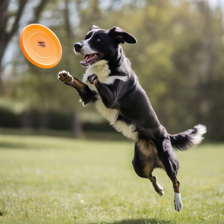

In [23]:
# Load and display our image
img = PIL.Image.open('2_19676_0.jpg').convert('RGB')
input = transform(img).cuda()
inv_transform(input)

In [24]:
predict(input)

Border collie	0.5494111776351929
kelpie	0.06371409446001053
collie	0.05149290710687637
Appenzeller	0.022944249212741852
EntleBucher	0.012125897221267223


## Capture and plot the attention weights

Let's plot the attention weights inside the 5th block. To do this, we capture the local variables inside the `forward` method of the `model.blocks[4].attn` layer:

In [25]:
# Here is where all the magic happens!
with nopdb.capture_call(model.blocks[4].attn.forward) as attn_call:
    predict(input)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.11/dist-packages/nopdb/nopdb.py", line 60, in start
    sys.settrace(self._trace_func)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.11/dist-packages/nopdb/nopdb.py", line 71, in stop
    sys.settrace(self._orig_trace_func)



Border collie	0.5494111776351929
kelpie	0.06371409446001053
collie	0.05149290710687637
Appenzeller	0.022944249212741852
EntleBucher	0.012125897221267223


In [26]:
# Check the local variables that we captured
attn_call.locals.keys()

dict_keys(['self', 'x', 'B', 'N', 'C', 'qkv', 'q', 'k', 'v', 'attn'])

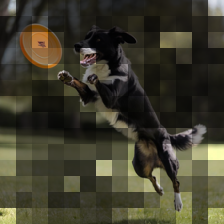

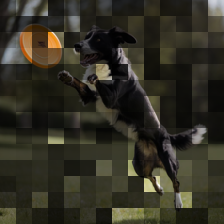

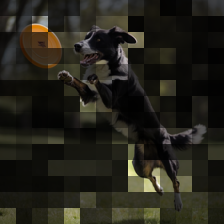

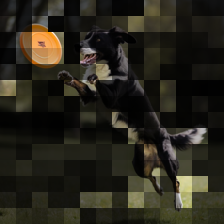

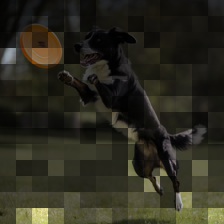

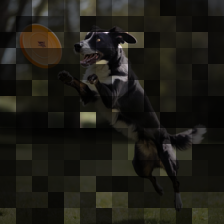

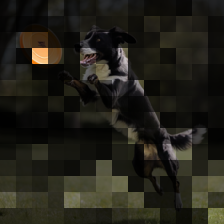

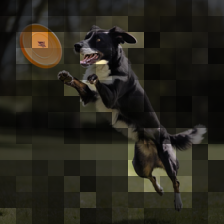

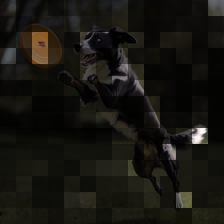

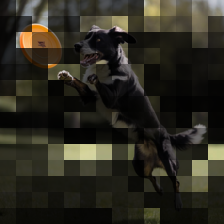

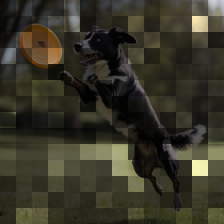

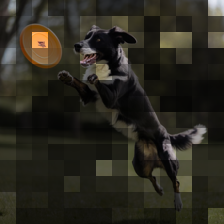

In [27]:
def plot_attention(input, attn):
    """Given an input image and the attention tensor, plot the average attention weight given to each image patch by each attention head."""
    with torch.no_grad():
        # Loop over attention heads
        for h_weights in attn:
            h_weights = h_weights.mean(axis=-2)  # Average over all attention keys
            h_weights = h_weights[1:]  # Skip the [class] token
            plot_weights(input, h_weights)

def plot_weights(input, patch_weights):
    """Display the image, dimming each patch according to the given weight."""
    # Multiply each patch of the input image by the corresponding weight
    plot = inv_normalize(input.clone())
    for i in range(patch_weights.shape[0]):
        x = i * 16 % 224
        y = i // (224 // 16) * 16
        plot[:, y:y + 16, x:x + 16] *= patch_weights[i]
    ipd.display(inv_transform(plot, normalize=False))

plot_attention(input, attn_call.locals['attn'][0])

## Modify the weights
We will now run the model again, but multiply the attention logits (pre-softmax activations) in all layers by a constant and observe how this changes the predictions. We are also going to capture and plot the (modified) weights in the 5th layer as before.

In [28]:
from timm.models.vision_transformer import Attention
Attention.forward??

In [29]:
# Set a breakpoint in the Attention module, just before the softmax
with nopdb.breakpoint(function=Attention.forward, line='attn = attn.softmax(dim=-1)') as bp, \
     nopdb.capture_call(model.blocks[4].attn.forward) as attn_call:
    bp.exec('attn = attn * 3')
    predict(input)

centipede	0.02664989046752453
nail	0.02572847343981266
chime	0.013699221424758434
worm fence	0.011036541312932968
panpipe	0.009389011189341545


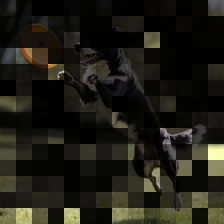

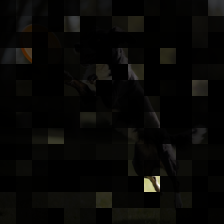

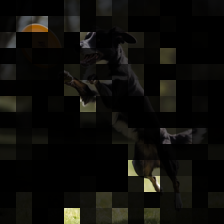

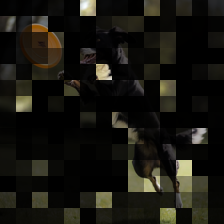

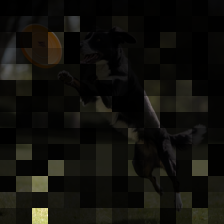

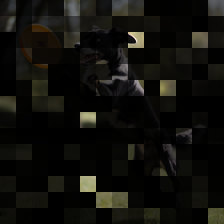

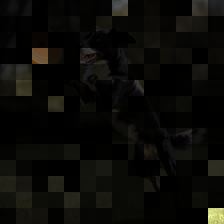

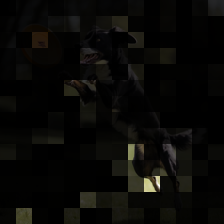

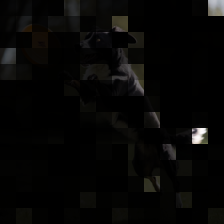

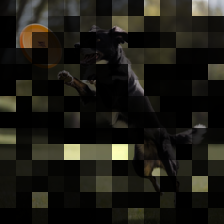

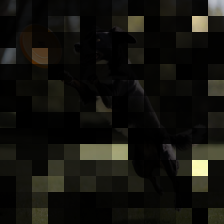

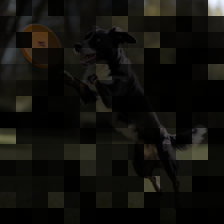

In [30]:
plot_attention(input, attn_call.locals['attn'][0])